In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pandarallel import pandarallel
from datetime import datetime
import powerlaw
pandarallel.initialize()
analyzer = SentimentIntensityAnalyzer()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [57]:
def plot(column, xlabel="", ylabel="", limit=0, n=100000, x_ticks=None, compute_powerlaw=False):
    fig = plt.figure(figsize=(12,10))
    ax = fig.gca()
    stuff = dict(dataset[column].value_counts())
    stuff = {k: v for k, v in sorted(stuff.items(), key=lambda item: item[1], reverse=True)}
    plt.scatter(list(stuff.keys())[limit:n+limit],list(stuff.values())[limit:n+limit])
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.ylim( (10**-0.1,10**8) )
    plt.xlim( (10**-1,10**8) )
    if x_ticks:
        ax.set(xticks=np.arange(0,100,10))
    if compute_powerlaw:
        results = powerlaw.Fit(list(stuff.values()), verbose=False)
        print("Alpha: ", str(results.alpha), " Delta: ", str(results.D), " max value: ", max(stuff.values()))
#     plt.title(column)
    plt.show()
    
def hist(column, xlabel="", ylabel="", n_bins=11):
    fig = plt.figure(figsize=(12,10))
    ax = fig.gca()
    stuff = dict(dataset[column].value_counts())
    stuff = {k: v for k, v in sorted(stuff.items(), key=lambda item: item[1], reverse=True)}
    plt.hist(list(dataset[column]), bins=n_bins)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    plt.show()
    
def lineplot(column, xlabel="", ylabel="", limit=0, n=100):
    fig = plt.figure(figsize=(12,10))
    ax = fig.gca()
    stuff = dict(dataset[column].value_counts())
    stuff = {k: v for k, v in sorted(stuff.items(), key=lambda item: item[1], reverse=False)}
    plt.plot(list(stuff.keys())[limit:n+limit],list(stuff.values())[limit:n+limit])
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set(xticks=np.arange(0,100,10))
#     plt.title(column)
    plt.show()

In [3]:
def sentiment(x):
    try:
        return analyzer.polarity_scores(x)["compound"]
    except:
        return 0
    
def timestamp(x):
    return datetime.utcfromtimestamp(x)

def bimester(x):
    if x % 2 == 0:
        return str(int(x/2))
    else:
        return str(int(x/2) + 1)

____
## POST

In [4]:
dataset = pd.read_csv("dataset/dataset.csv", header=0)

In [7]:
dataset["sentiment"] = dataset["title"].parallel_apply(lambda x: sentiment(x))

In [19]:
dataset.head(2)

,post_id,author_id,author,subreddit_id,subreddit,created_utc,num_comments,num_crossposts,nsfw,score,title,is_video,has_image,total_awards_received,is_part_of_collection,is_self_post
0,ewxgwo,t2_46zsxucy,Trashpotatolol,t5_n9nn1,Market76,1580515200,4,0,False,2,[XB1] H: Bloodied explosive lvc minigun W: Blo...,False,False,0,[],False
1,ewxgwr,t2_6vjwa,NBA_MOD,t5_2qo4s,nba,1580515200,380,0,False,20,GAME THREAD: Memphis Grizzlies (24-24) @ New O...,False,False,0,[],True


In [18]:
dataset["total_awards_received"].max()

5638

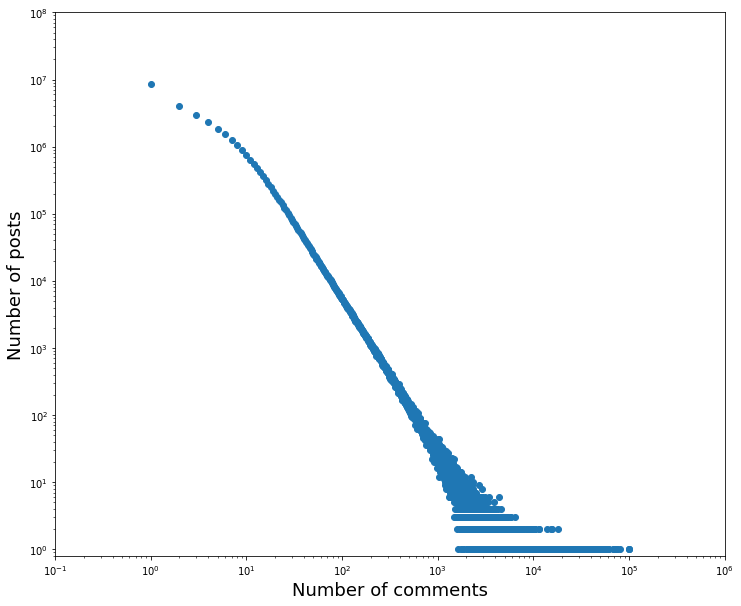

In [41]:
plot("num_comments", "Number of comments", "Number of posts", compute_powerlaw=False)

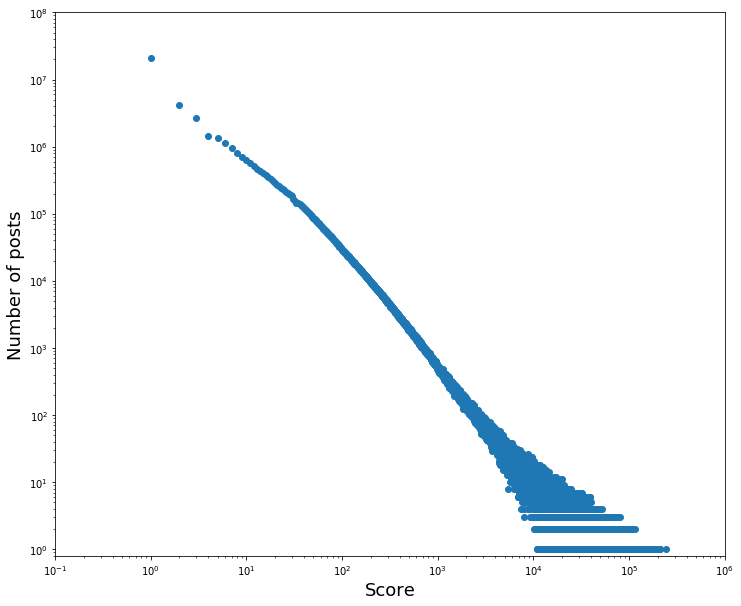

In [42]:
plot("score", "Score", "Number of posts", compute_powerlaw=False)

/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Alpha:  1.3863147715860178  Delta:  0.027350160558798353  max value:  52079119


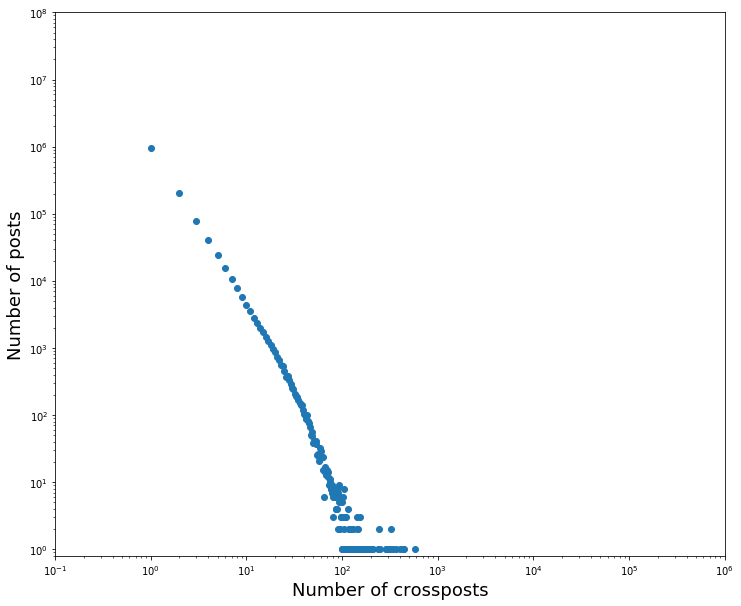

In [43]:
plot("num_crossposts", "Number of crossposts", "Number of posts", compute_powerlaw=True)

/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Alpha:  1.3744709228415686  Delta:  0.03358625930566761  max value:  53096732


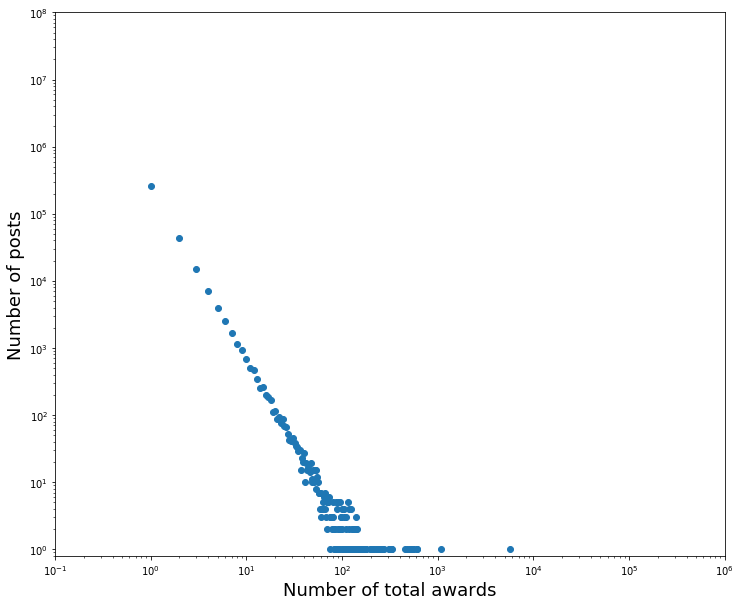

In [44]:
plot("total_awards_received", "Number of total awards", "Number of posts", compute_powerlaw=True)

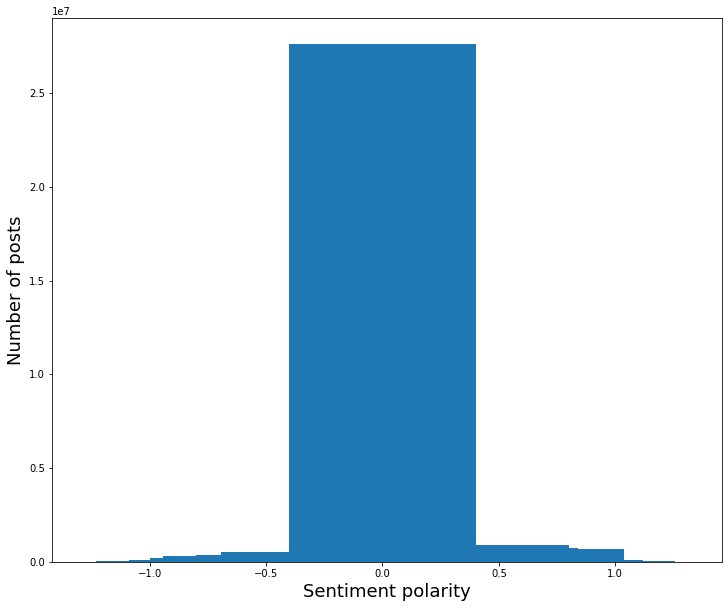

In [20]:
plot("sentiment", "Sentiment polarity", "Number of posts", n=500)

In [26]:
# PERCENTUALE SENTIMENT
limit = 500
stuff = dict(dataset["sentiment"].value_counts())
stuff = {k: v for k, v in sorted(stuff.items(), key=lambda item: item[1], reverse=True)}
below = 0
total = 0
i = 0
for key, value in stuff.items():
    if i < limit:
        if -0.2 <= key <= 0.2:
            below += value
        total += value
        i += 1
print("PERCENTUALE DEGLI ELEMENTI CON 0 SENTIMENT: ", str(total / sum(list(stuff.values()))))

PERCENTUALE DEGLI ELEMENTI CON 0 SENTIMENT:  0.9374085617379974


___
## AUTHORS

In [45]:
dataset = pd.read_csv("dataset/authors.csv", header=0)

In [25]:
dataset["year"] = dataset["created_utc"].parallel_apply(lambda x: timestamp(x).year)

In [49]:
def compute_nbimester(x):
    year, bimester = x.split("-")
    year = 2020 - int(year)
    return year * 6 + int(bimester) - 1

dataset["bimester"] = dataset["created_utc"].parallel_apply(lambda x: str(timestamp(x).year) + "-" + bimester(timestamp(x).month))
dataset["n_bimester"] = dataset["bimester"].parallel_apply(lambda x: compute_nbimester(x))
dataset[["bimester", "n_bimester"]].head()

,bimester,n_bimester
0,2019-5,10
1,2012-1,48
2,2016-1,24
3,2012-3,50
4,2017-2,19


In [47]:
dataset["karma"].max()

35249636

In [44]:
s = dataset["n_bimester"].value_counts()
s[s == 0]

Series([], Name: n_bimester, dtype: int64)

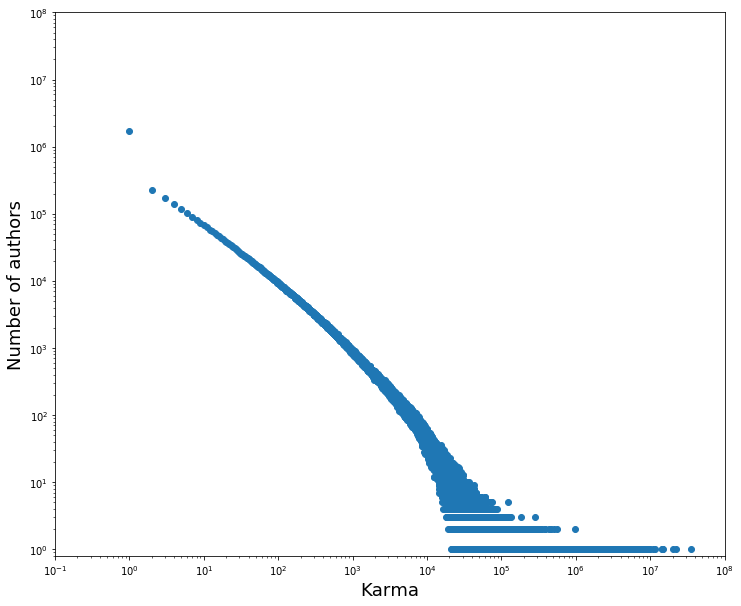

In [51]:
plot("karma", "Karma", "Number of authors", compute_powerlaw=False)

In [83]:
dataset[dataset["bimester"] == "2020-1"].head()

,Unnamed: 0,author_id,author,created_utc,is_gold,is_suspended,karma,quarter,bimester
23,23,t2_5jk2ohkq,Alvacox,1.580167e+09,False,False,1,20201,2020-1
33,33,t2_5d51fx9b,BhootuGirl,1.578096e+09,False,False,10,20201,2020-1
46,46,t2_5aup1tpb,TheThrowAwayWookie,1.580513e+09,False,False,53,20201,2020-1
61,61,t2_5gbra2um,mediumbot,1.579114e+09,False,False,11,20201,2020-1
62,62,t2_5boerck2,Tjhodskins19,1.580515e+09,False,False,1,20201,2020-1


89
Alpha:  1.9060310922247021  Delta:  0.09082104119360757  max value:  1370410


/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


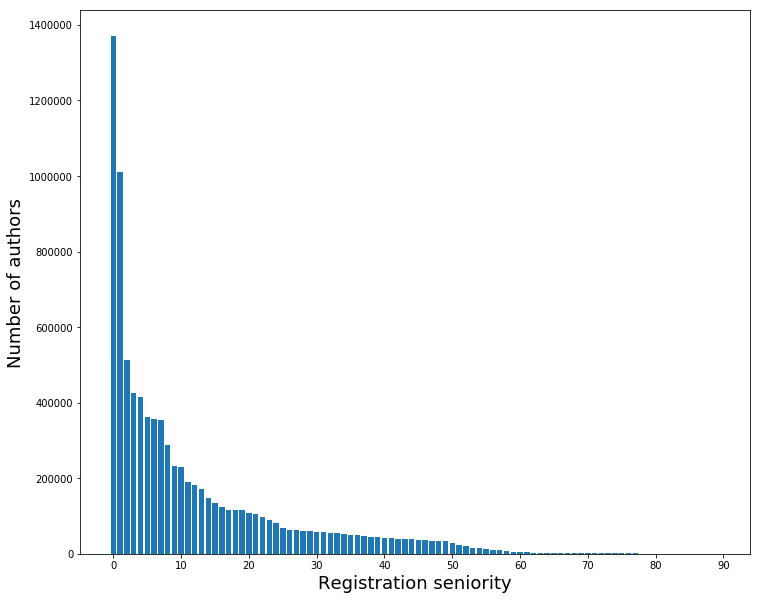

In [52]:
def plot(column, xlabel="", ylabel="", limit=0, n=100, x_ticks=None, compute_powerlaw=False):
    fig = plt.figure(figsize=(12,10))
    ax = fig.gca()
    stuff = dict(dataset[column].value_counts())
    stuff = {k: v for k, v in sorted(stuff.items(), key=lambda item: item[1], reverse=True)}
    x = [lol for lol in range(0, len(list(stuff.values())[limit:n+limit]), 1)]
    print(max(x))
    y = list(stuff.values())[limit:n+limit]
    plt.bar(x,y)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    if x_ticks:
        ax.set(xticks=np.arange(0,100,10))
    if compute_powerlaw:
        results = powerlaw.Fit(list(stuff.values()), verbose=False)
        print("Alpha: ", str(results.alpha), " Delta: ", str(results.D), " max value: ", max(stuff.values()))
#     plt.title(column)
    plt.show()



plot("bimester", "Registration seniority", "Number of authors", x_ticks=-1, compute_powerlaw=True)

In [23]:
print("MIN: ", dataset["created_utc"].min(), timestamp(dataset["created_utc"].min()))
print("MAX: ", dataset["created_utc"].max(), timestamp(dataset["created_utc"].max()))

MIN:  1137700161.0 2006-01-19 19:49:21
MAX:  1596482497.0 2020-08-03 19:21:37


___
## SUBREDDIT

In [53]:
dataset = pd.read_csv("dataset/subreddits.csv", header=0)

In [54]:
dataset["year"] = dataset["created_utc"].parallel_apply(lambda x: timestamp(x).year)

In [62]:
dataset["subscribers"].max()

67092933.0

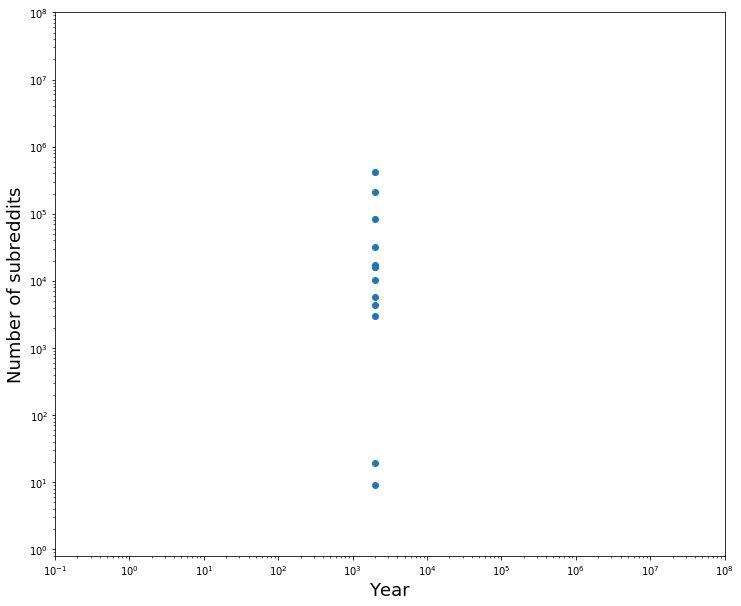

In [61]:
plot("year", "Year", "Number of subreddits")

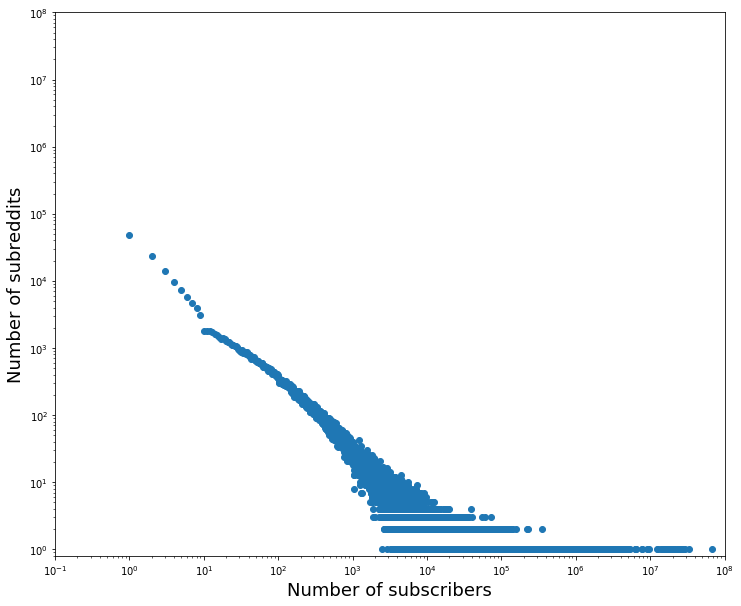

In [60]:
plot("subscribers", "Number of subscribers", "Number of subreddits", compute_powerlaw=False)

In [28]:
dataset["sentiment"] = dataset["description"].parallel_apply(lambda x: sentiment(x))

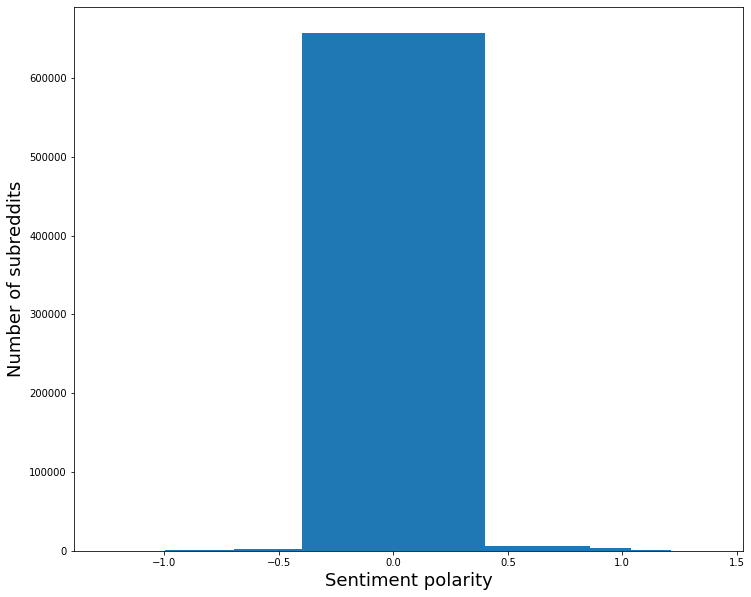

In [31]:
plot("sentiment", "Sentiment polarity", "Number of subreddits", n=500)

In [30]:
# PERCENTUALE SENTIMENT
limit = 500
stuff = dict(dataset["sentiment"].value_counts())
stuff = {k: v for k, v in sorted(stuff.items(), key=lambda item: item[1], reverse=True)}
below = 0
total = 0
i = 0
for key, value in stuff.items():
    if i < limit:
        if -0.2 <= key <= 0.2:
            below += value
        total += value
        i += 1
print("PERCENTUALE DEGLI ELEMENTI CON 0 SENTIMENT: ", str(total / sum(list(stuff.values()))))

PERCENTUALE DEGLI ELEMENTI CON 0 SENTIMENT:  0.9198936388098282


In [24]:
print("MIN: ", dataset["created_utc"].min(), timestamp(dataset["created_utc"].min()))
print("MAX: ", dataset["created_utc"].max(), timestamp(dataset["created_utc"].max()))

MIN:  1137700161.0 2006-01-19 19:49:21
MAX:  1596482497.0 2020-08-03 19:21:37
